# Import các thư viện cần thiết

In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np


from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Đọc dữ liệu

In [2]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv',index_col='date')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2022-01-01 to 2023-12-31
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_holiday       730 non-null    bool   
 1   temperature      730 non-null    float64
 2   new_total_usage  730 non-null    float64
 3   weekday_0        730 non-null    bool   
 4   weekday_1        730 non-null    bool   
 5   weekday_2        730 non-null    bool   
 6   weekday_3        730 non-null    bool   
 7   weekday_4        730 non-null    bool   
 8   weekday_5        730 non-null    bool   
 9   weekday_6        730 non-null    bool   
dtypes: bool(8), float64(2)
memory usage: 22.8+ KB


# Chia tập validate

In [4]:
df_validate = df_train.iloc[-100:, :]
df_train = df_train.iloc[:-100, :]

In [5]:
df_validate.tail()

,is_holiday,temperature,new_total_usage,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,
2023-12-27,False,22.45,3542.0,False,False,True,False,False,False,False
2023-12-28,False,23.40,3432.0,False,False,False,True,False,False,False
2023-12-29,False,24.00,3311.0,False,False,False,False,True,False,False
2023-12-30,False,23.62,1452.0,False,False,False,False,False,True,False
2023-12-31,False,23.55,1078.0,False,False,False,False,False,False,True


# Chuẩn bị dữ liệu để dự đoán

## Chuyển giá trị True/False về 1/0

In [6]:
def convert_columns_to_int(df, weekday_cols_prefix='weekday_', holiday_col='is_holiday', num_weekdays=6):
    """
    Chuyển đổi các cột 'weekday' và 'is_holiday' của DataFrame sang kiểu dữ liệu int.

    Tham số:
    - df: DataFrame cần chuyển đổi.
    - weekday_cols_prefix: Tiền tố của các cột 'weekday'. Mặc định là 'weekday_'.
    - holiday_col: Tên cột ngày lễ cần chuyển đổi. Mặc định là 'is_holiday'.
    - num_weekdays: Số lượng cột 'weekday' cần chuyển đổi (mặc định là 6).
    
    Trả về:
    - DataFrame với các cột đã được chuyển sang kiểu int.
    """
    
    # Chuyển đổi các cột weekday_{i} thành int
    for i in range(0, num_weekdays + 1):  # Lặp từ 1 tới num_weekdays
        df[f'{weekday_cols_prefix}{i}'] = df[f'{weekday_cols_prefix}{i}'].astype(int)
    
    # Chuyển đổi cột is_holiday thành int
    df[holiday_col] = df[holiday_col].astype(int)
    
    return df

In [7]:
df_train = convert_columns_to_int(df=df_train)
df_validate = convert_columns_to_int(df=df_validate)
df_test = convert_columns_to_int(df=df_test)

## Chuyển index về datetime

In [8]:
df_train.index = pd.to_datetime(df_train.index)
df_validate.index = pd.to_datetime(df_validate.index)
df_test.index = pd.to_datetime(df_test.index)

## Chuyển freq

In [9]:
df_train = df_train.asfreq('D')  
df_validate = df_validate.asfreq('D')  
df_test = df_test.asfreq('D')  

## Chia tập X, y

In [10]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
X_validate = df_validate.iloc[:,:-1]
y_validate = df_validate.iloc[:,-1]
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]


In [11]:
X_train.shape

(630, 9)

In [12]:
y_train.shape

(630,)

In [13]:
X_test.shape

(190, 9)

In [14]:
y_test.shape

(190,)

# Seasonal components

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 630 entries, 2022-01-01 to 2023-09-22
Freq: D
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_holiday       630 non-null    int32  
 1   temperature      630 non-null    float64
 2   new_total_usage  630 non-null    float64
 3   weekday_0        630 non-null    int32  
 4   weekday_1        630 non-null    int32  
 5   weekday_2        630 non-null    int32  
 6   weekday_3        630 non-null    int32  
 7   weekday_4        630 non-null    int32  
 8   weekday_5        630 non-null    int32  
 9   weekday_6        630 non-null    int32  
dtypes: float64(2), int32(8)
memory usage: 34.5 KB


In [16]:
ts_decomposition = seasonal_decompose(x=df_train['new_total_usage'], model='additive')
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

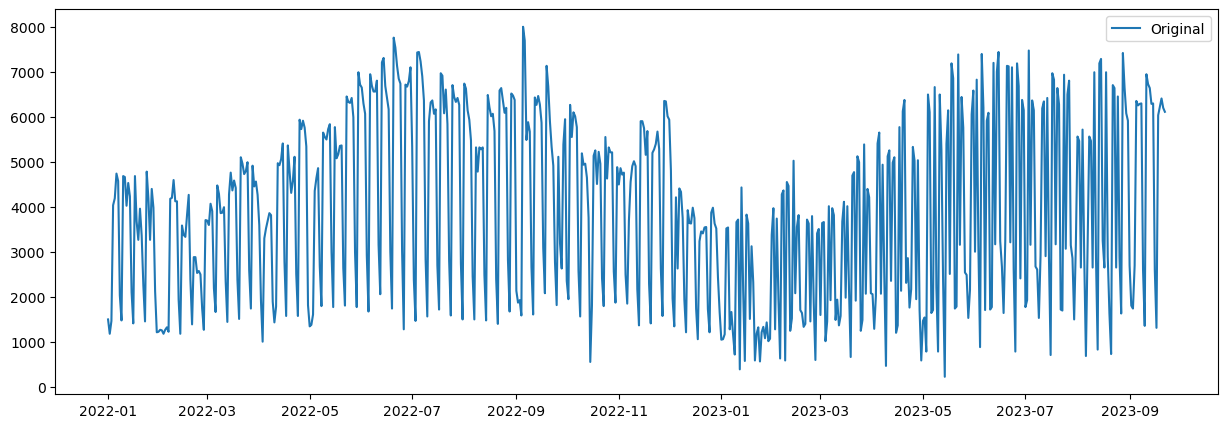

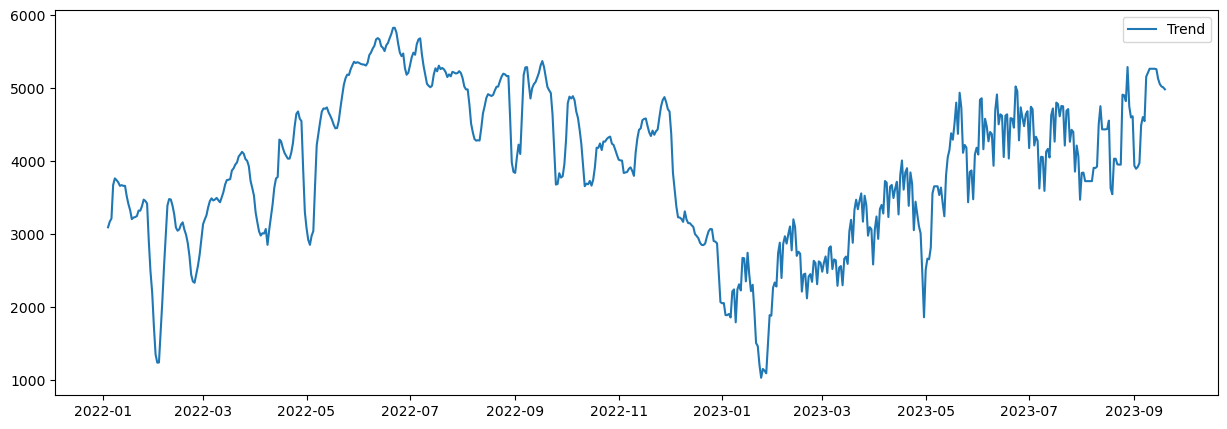

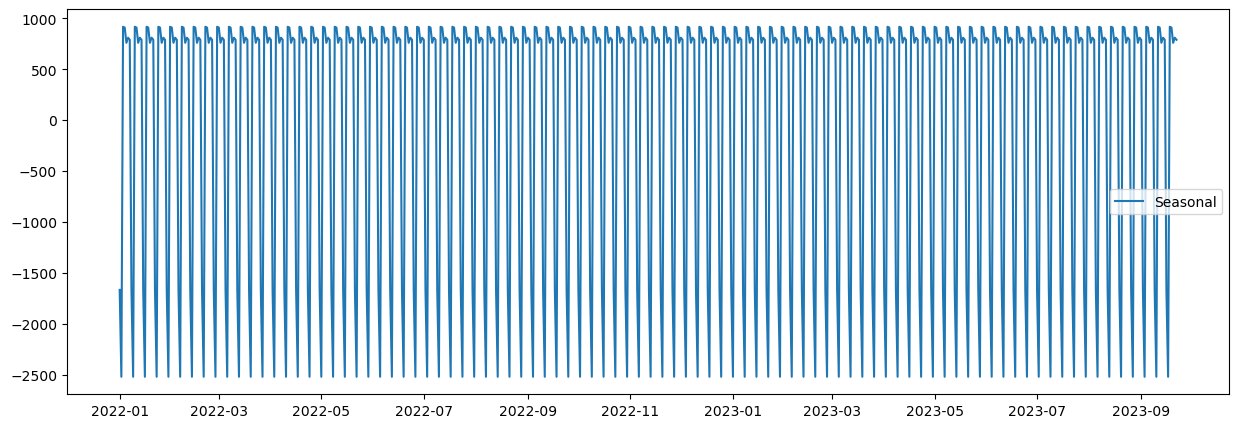

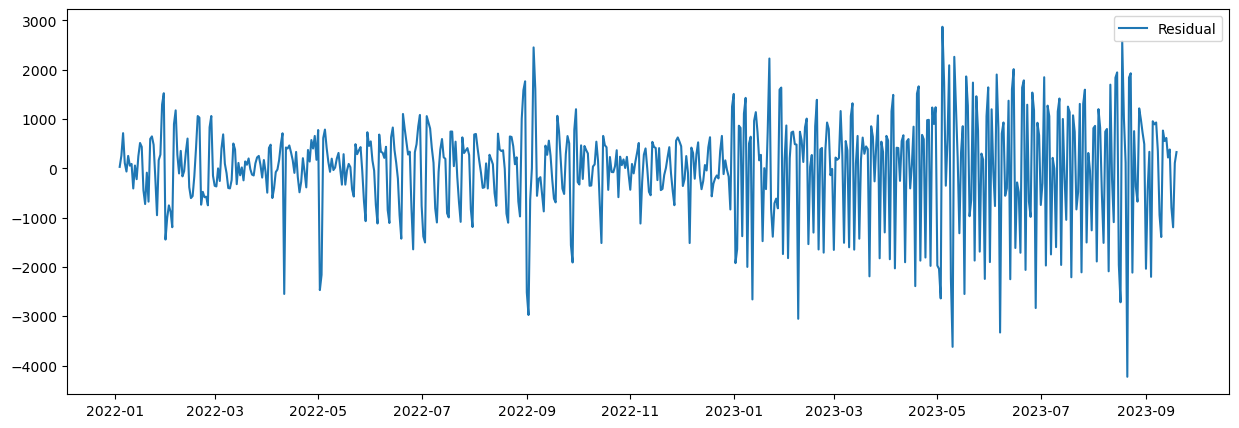

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df_train['new_total_usage'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

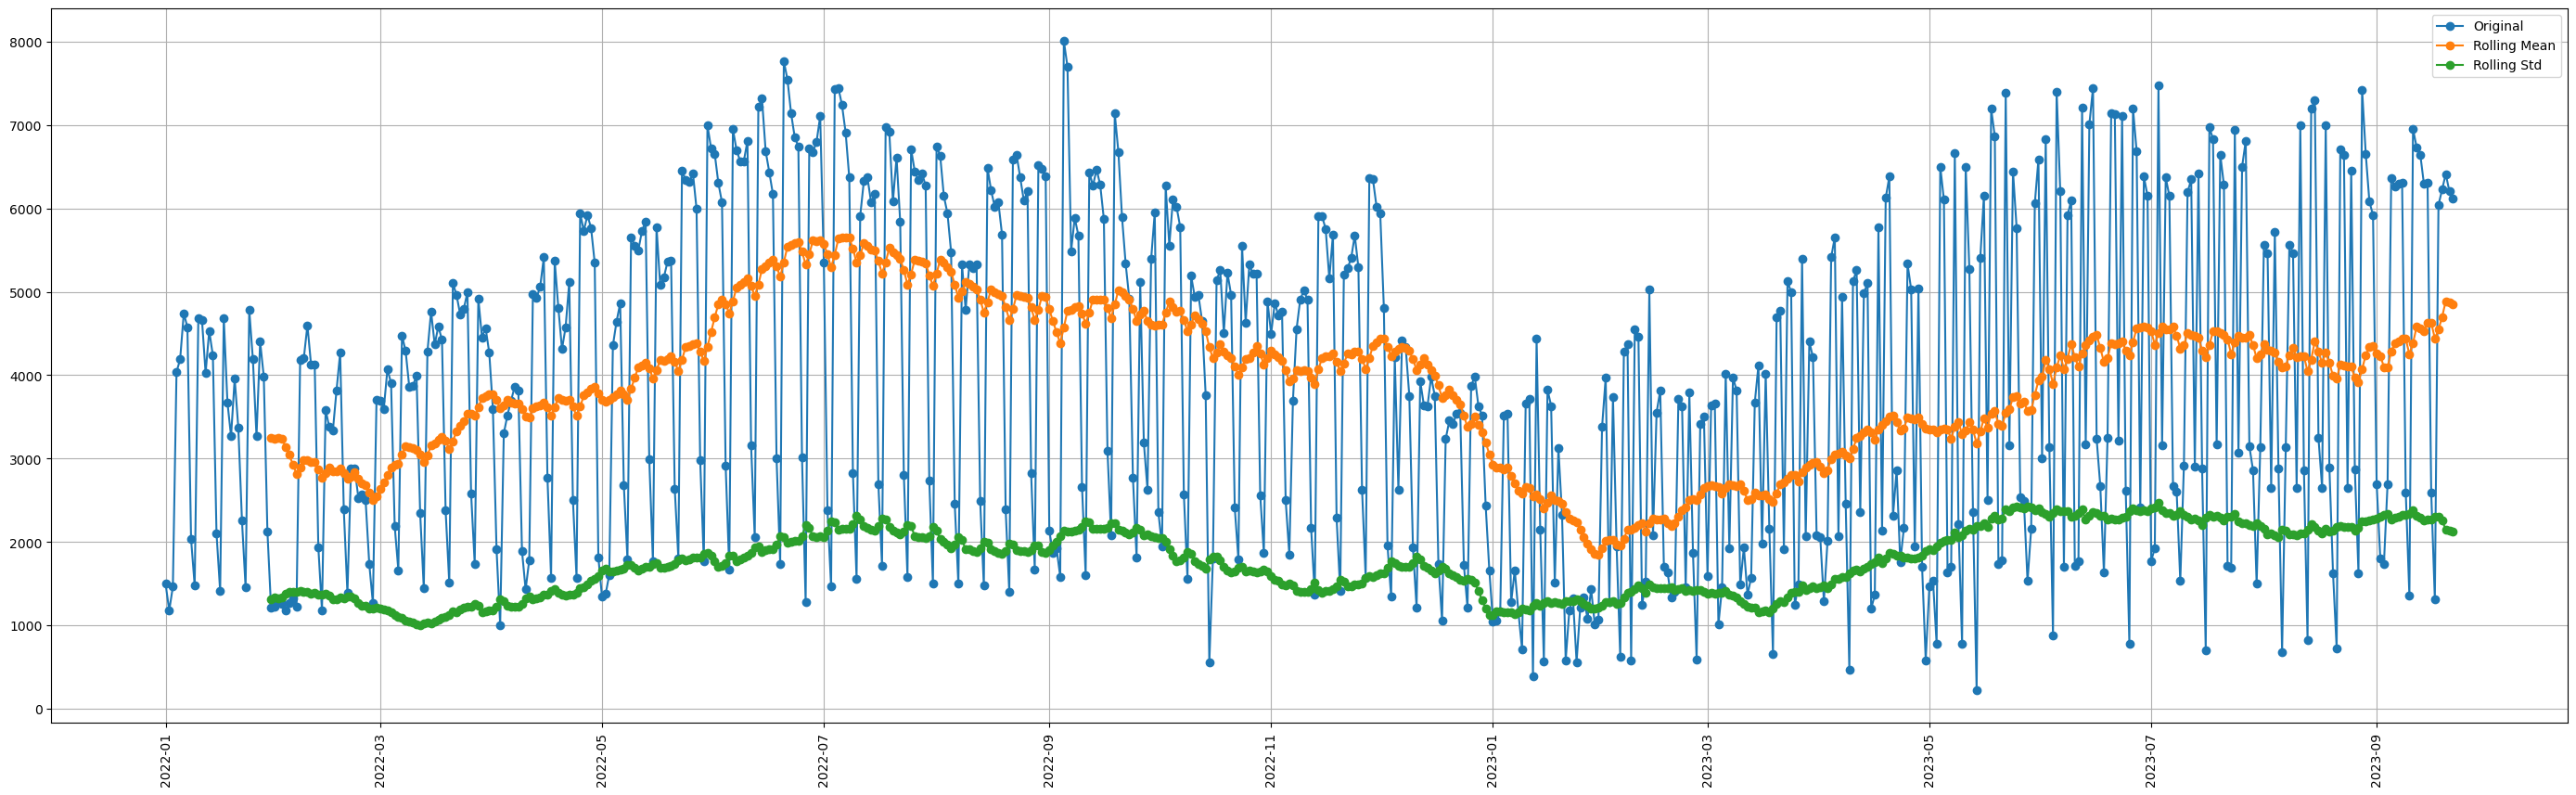

In [18]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df_train['new_total_usage'], marker='o', label='Original')
plt.plot(df_train['new_total_usage'].rolling(window=30).mean(), marker='o', label='Rolling Mean')
plt.plot(df_train['new_total_usage'].rolling(window=30).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Kiểm tra tính stationary:
- Time series được coi là stationary khi constant mean, constant variance và constant autocorrelation

In [19]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):
    

    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [20]:
for name, column in df_train.items():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "is_holiday" 
    -----------------------------------------------
ADF Statistic: -9.870513
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationary


    Augmented Dickey-Fuller Test on "temperature" 
    -----------------------------------------------
ADF Statistic: -2.100808
p-value: 0.244190
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Non-stationary


    Augmented Dickey-Fuller Test on "new_total_usage" 
    -----------------------------------------------
ADF Statistic: -1.352065
p-value: 0.605029
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Non-stationary


    Augmented Dickey-Fuller Test on "weekday_0" 
    -----------------------------------------------
ADF Statistic: -21499999661967104.000000
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationary


    Augmented Dickey-Fuller Test on "weekday_1" 
    -----------------------------------------------
ADF Statistic: -136970

## Nhận xét:
- Trừ new_total_usage và temperature thì các feature còn lại đều là stationary

# Fit model

In [21]:
X_train.head()

,is_holiday,temperature,new_total_usage,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5
date,,,,,,,,,
2022-01-01,1,21.89,1496.0,0,0,0,0,0,1
2022-01-02,0,21.96,1177.0,0,0,0,0,0,0
2022-01-03,1,21.99,1463.0,1,0,0,0,0,0
2022-01-04,0,22.57,4037.0,0,1,0,0,0,0
2022-01-05,0,22.97,4191.0,0,0,1,0,0,0


In [22]:
arima = pm.auto_arima(y_train,X=X_train,m=31, seasonal=False, trace=2,d=None,start_p=0, start_q=0,  max_p=12, max_q=12,   D=None,        
                    stationary=True,test='adf', error_action='trace')

c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (31) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1022.848, Time=0.65 sec
First viable model found (-1022.848)
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1568.142, Time=0.64 sec
New best model found (-1568.142 < -1022.848)
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1264.114, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2419.651, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1597.686, Time=0.37 sec
New best model found (-1597.686 < -1568.142)
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1675.184, Time=0.45 sec
New best model found (-1675.184 < -1597.686)
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1673.190, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1672.043, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-466.894, Time=0.98 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-1670.351, Time=0.52 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1676.876, Time=0.40 sec
New best model found (-1676.876 < -1675.184)
 ARIM

c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-465.804, Time=0.40 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1672.082, Time=0.49 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 8.283 seconds


In [23]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  630
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 851.438
Date:                Sat, 07 Sep 2024   AIC                          -1676.876
Time:                        13:28:29   BIC                          -1619.081
Sample:                    01-01-2022   HQIC                         -1654.427
                         - 09-22-2023                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
is_holiday          0.0239      0.011      2.236      0.025       0.003       0.045
temperature         0.0370      0.001     42.353      0.000       0.035       0.039
new_total_usage -3.406e-05   2.11e-06    -16.159      0.000   -3.82e-05   -2.99e-05
weekday_0          -0.8063      0.012    -69.137      0.000      -0.829      -0.783
weekday_1          -0.8028      0.012    -64.954      0.000      -0.827      -0.779
weekday_2          -0.8130      0.010    -80.866      0.000      -0.833      -0.793
weekday_3          -0.8152      0.011    -75.338      0.000      -0.836      -0.794
weekday_4          -0.8150      0.012    -65.233      0.000      -0.839      -0.790
weekday_5          -0.8962      0.008   -118.443      0.000      -0.911      -0.881
ar.L1               0.4508      0.045      9.935      0.000       0.362       0.540
ar.L2               0.0921      0.057      1.619      0.105      -0.019       0.204
ar.L3               0.3432      0.041      8.324      0.000       0.262       0.424
sigma2              0.0039      0.000     12.473      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                20.28
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
arima.params

<bound method ARIMA.params of ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>

In [25]:
pred=arima.predict(n_periods=100, X=X_validate, alpha=0.05)
pred

2023-09-23    0.016312
2023-09-24    0.876506
2023-09-25    0.027025
2023-09-26   -0.003679
2023-09-27   -0.034392
                ...   
2023-12-27   -0.103261
2023-12-28   -0.066625
2023-12-29   -0.040044
2023-12-30   -0.071970
2023-12-31    0.834359
Freq: D, Length: 100, dtype: float64

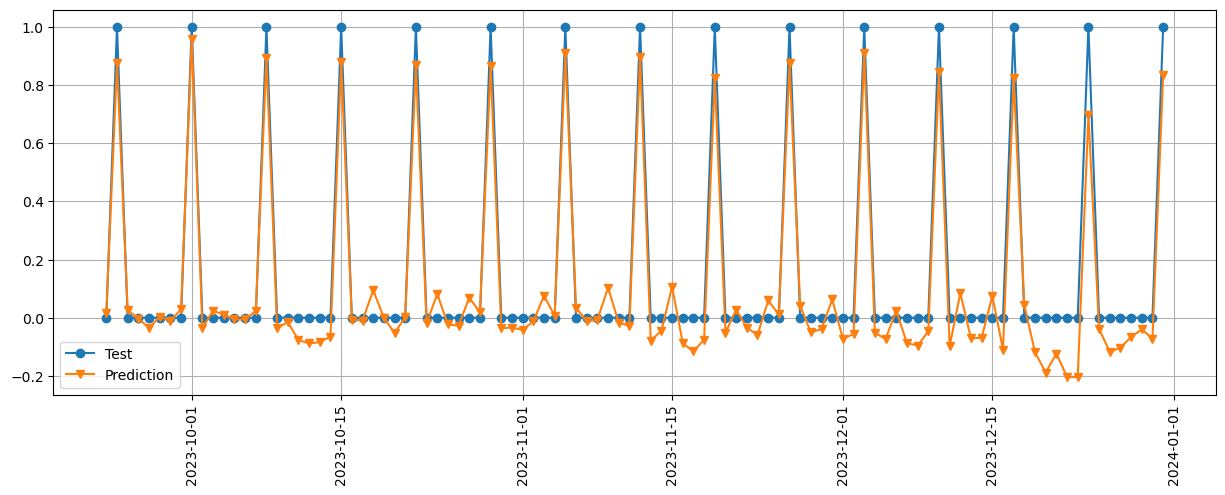

In [26]:
plt.figure(figsize=(15,5))
plt.grid()
#plt.plot(data['Period'][:-10], train['GDP_GROWTH'], marker='o', label='Train')
plt.plot(df_validate.index,y_validate, marker='o', label='Test')
plt.plot(df_validate.index,pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [27]:
mape=mean_absolute_percentage_error(y_validate, pred)
print("Mean Absolute Percentage Error", mape)


Mean Absolute Percentage Error 211255998440524.16


In [28]:
mse=mean_squared_error(y_validate, pred)
print("Mean Squared Error",mse)

Mean Squared Error 0.007399239716176238


In [29]:
print("RMSE", (mse)**0.5)

RMSE 0.08601883349695134


In [30]:
print("AIC values {}".format(arima.aic()))

AIC values -1676.8757266057673


# ARIMA

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series into its trend, seasonal and residuals components
result_decompose = seasonal_decompose(df_train['new_total_usage'], model='additive')


In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 630 entries, 2022-01-01 to 2023-09-22
Freq: D
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_holiday       630 non-null    int32  
 1   temperature      630 non-null    float64
 2   new_total_usage  630 non-null    float64
 3   weekday_0        630 non-null    int32  
 4   weekday_1        630 non-null    int32  
 5   weekday_2        630 non-null    int32  
 6   weekday_3        630 non-null    int32  
 7   weekday_4        630 non-null    int32  
 8   weekday_5        630 non-null    int32  
 9   weekday_6        630 non-null    int32  
dtypes: float64(2), int32(8)
memory usage: 34.5 KB


Text(0.5, 1.0, 'residuals')

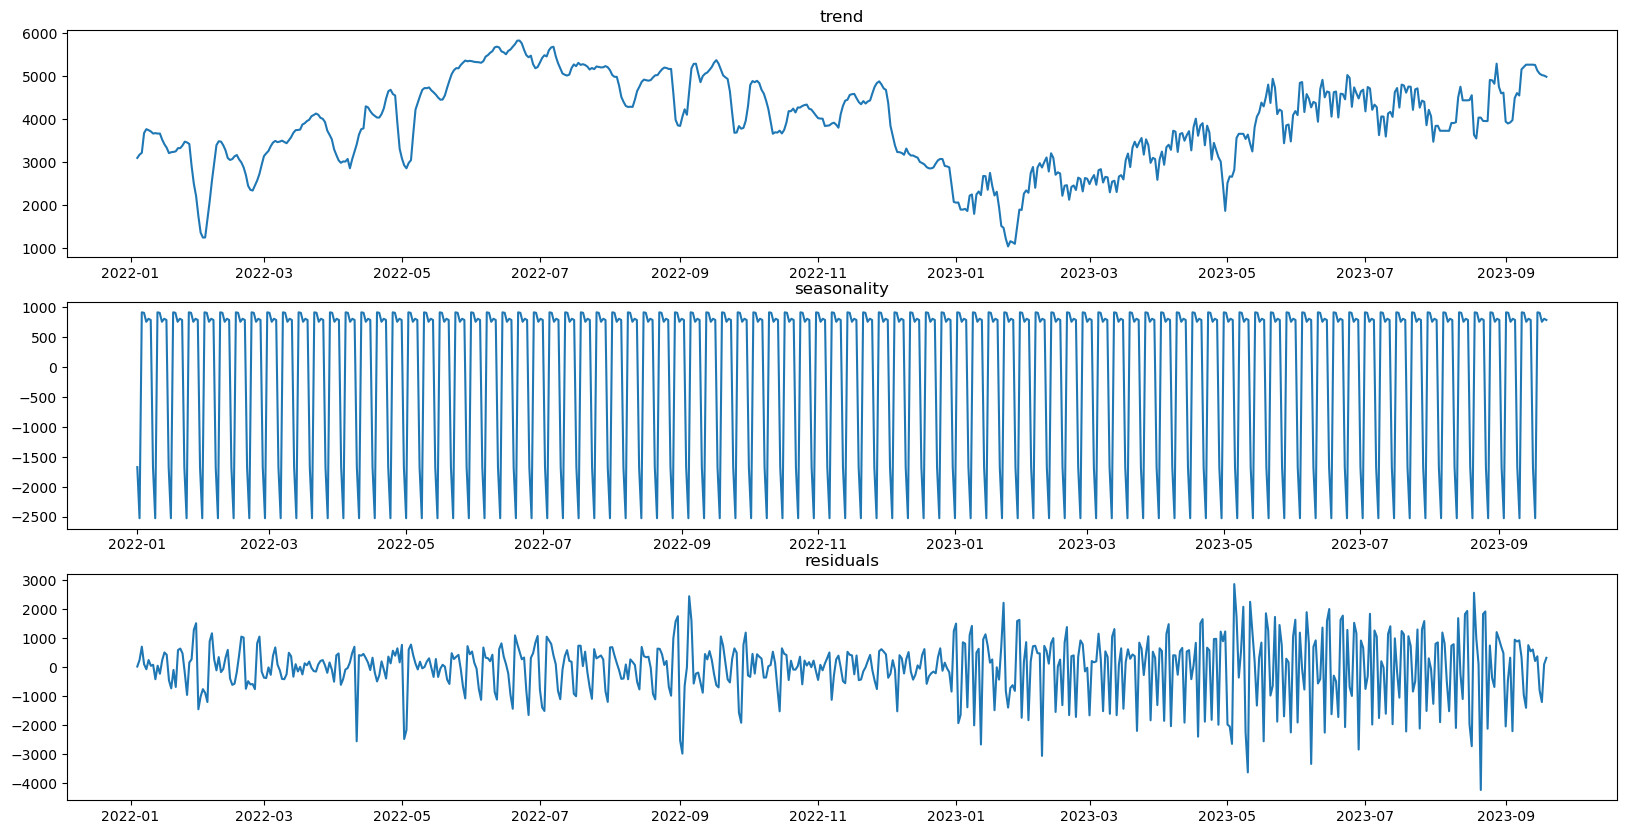

In [33]:
trend     = result_decompose.trend
seasonal  = result_decompose.seasonal
residuals = result_decompose.resid
# plot every component
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(trend)
plt.title('trend')
plt.subplot(312)
plt.plot(seasonal)
plt.title('seasonality')
plt.subplot(313)
plt.plot(residuals)
plt.title('residuals')